In [1]:
import os,glob
import pandas as pd
import matplotlib.pyplot as plt
import pygmt
import pickle
import warnings  
import numpy as np
from obspy.geodetics.base import gps2dist_azimuth
warnings.filterwarnings("ignore")

In [37]:
PierceDep = 100
file = f'PP_{PierceDep}.csv'
df = pd.read_csv(file)
PKLpath = '/Volumes/home/Research/STEP/01_Split'

In [38]:
def PygmtBegin(figmap, region, title):
    figmap.basemap(region=region, projection="M15c", frame = ['x1f0.5', 'y1f0.5', f'nSeW+t"{title}"'])
    figmap.grdimage('@earth_relief_15s',region =region,cmap='eleva.cpt',monochrome=True, shading=True, transparency=60)
    figmap.coast(resolution = 'h', shorelines ='1/thinnest,black', water='white', borders = '1/0.25p')
#     figmap.plot(data=smooth_fault,pen='1p,brown')
    Volcano = '/Volumes/home/Research/DataBase/01_Armenia/02_Volcano_list.csv'
    dv = pd.read_csv(Volcano)
    figmap.plot(x=dv['lon'],y=dv['lat'],style="kvolcano/0.4c", pen='0.1p,black', color="black")

In [39]:
#=======for kmean ========
print('=======start kmean')
from sklearn.cluster import KMeans
x=[]
for lonn, latt in zip(df['plon'],df['plat']):
    x.append([lonn,latt])
X = np.array(x)

CLU={}
kmeans = KMeans(n_clusters=22)
kmeans_fit = kmeans.fit(X)
label = (kmeans_fit.labels_).tolist()
CLU['cluster'] = label
CLU = pd.DataFrame(CLU)
dc = pd.concat([df, CLU], axis=1)
dc = dc.sort_values(by=['cluster'])
dc.to_csv(f'Cluster_{PierceDep}/PP{PierceDep}_cluster.csv', index=False)     
print('=======end kmean')

=======start kmean
=======end kmean


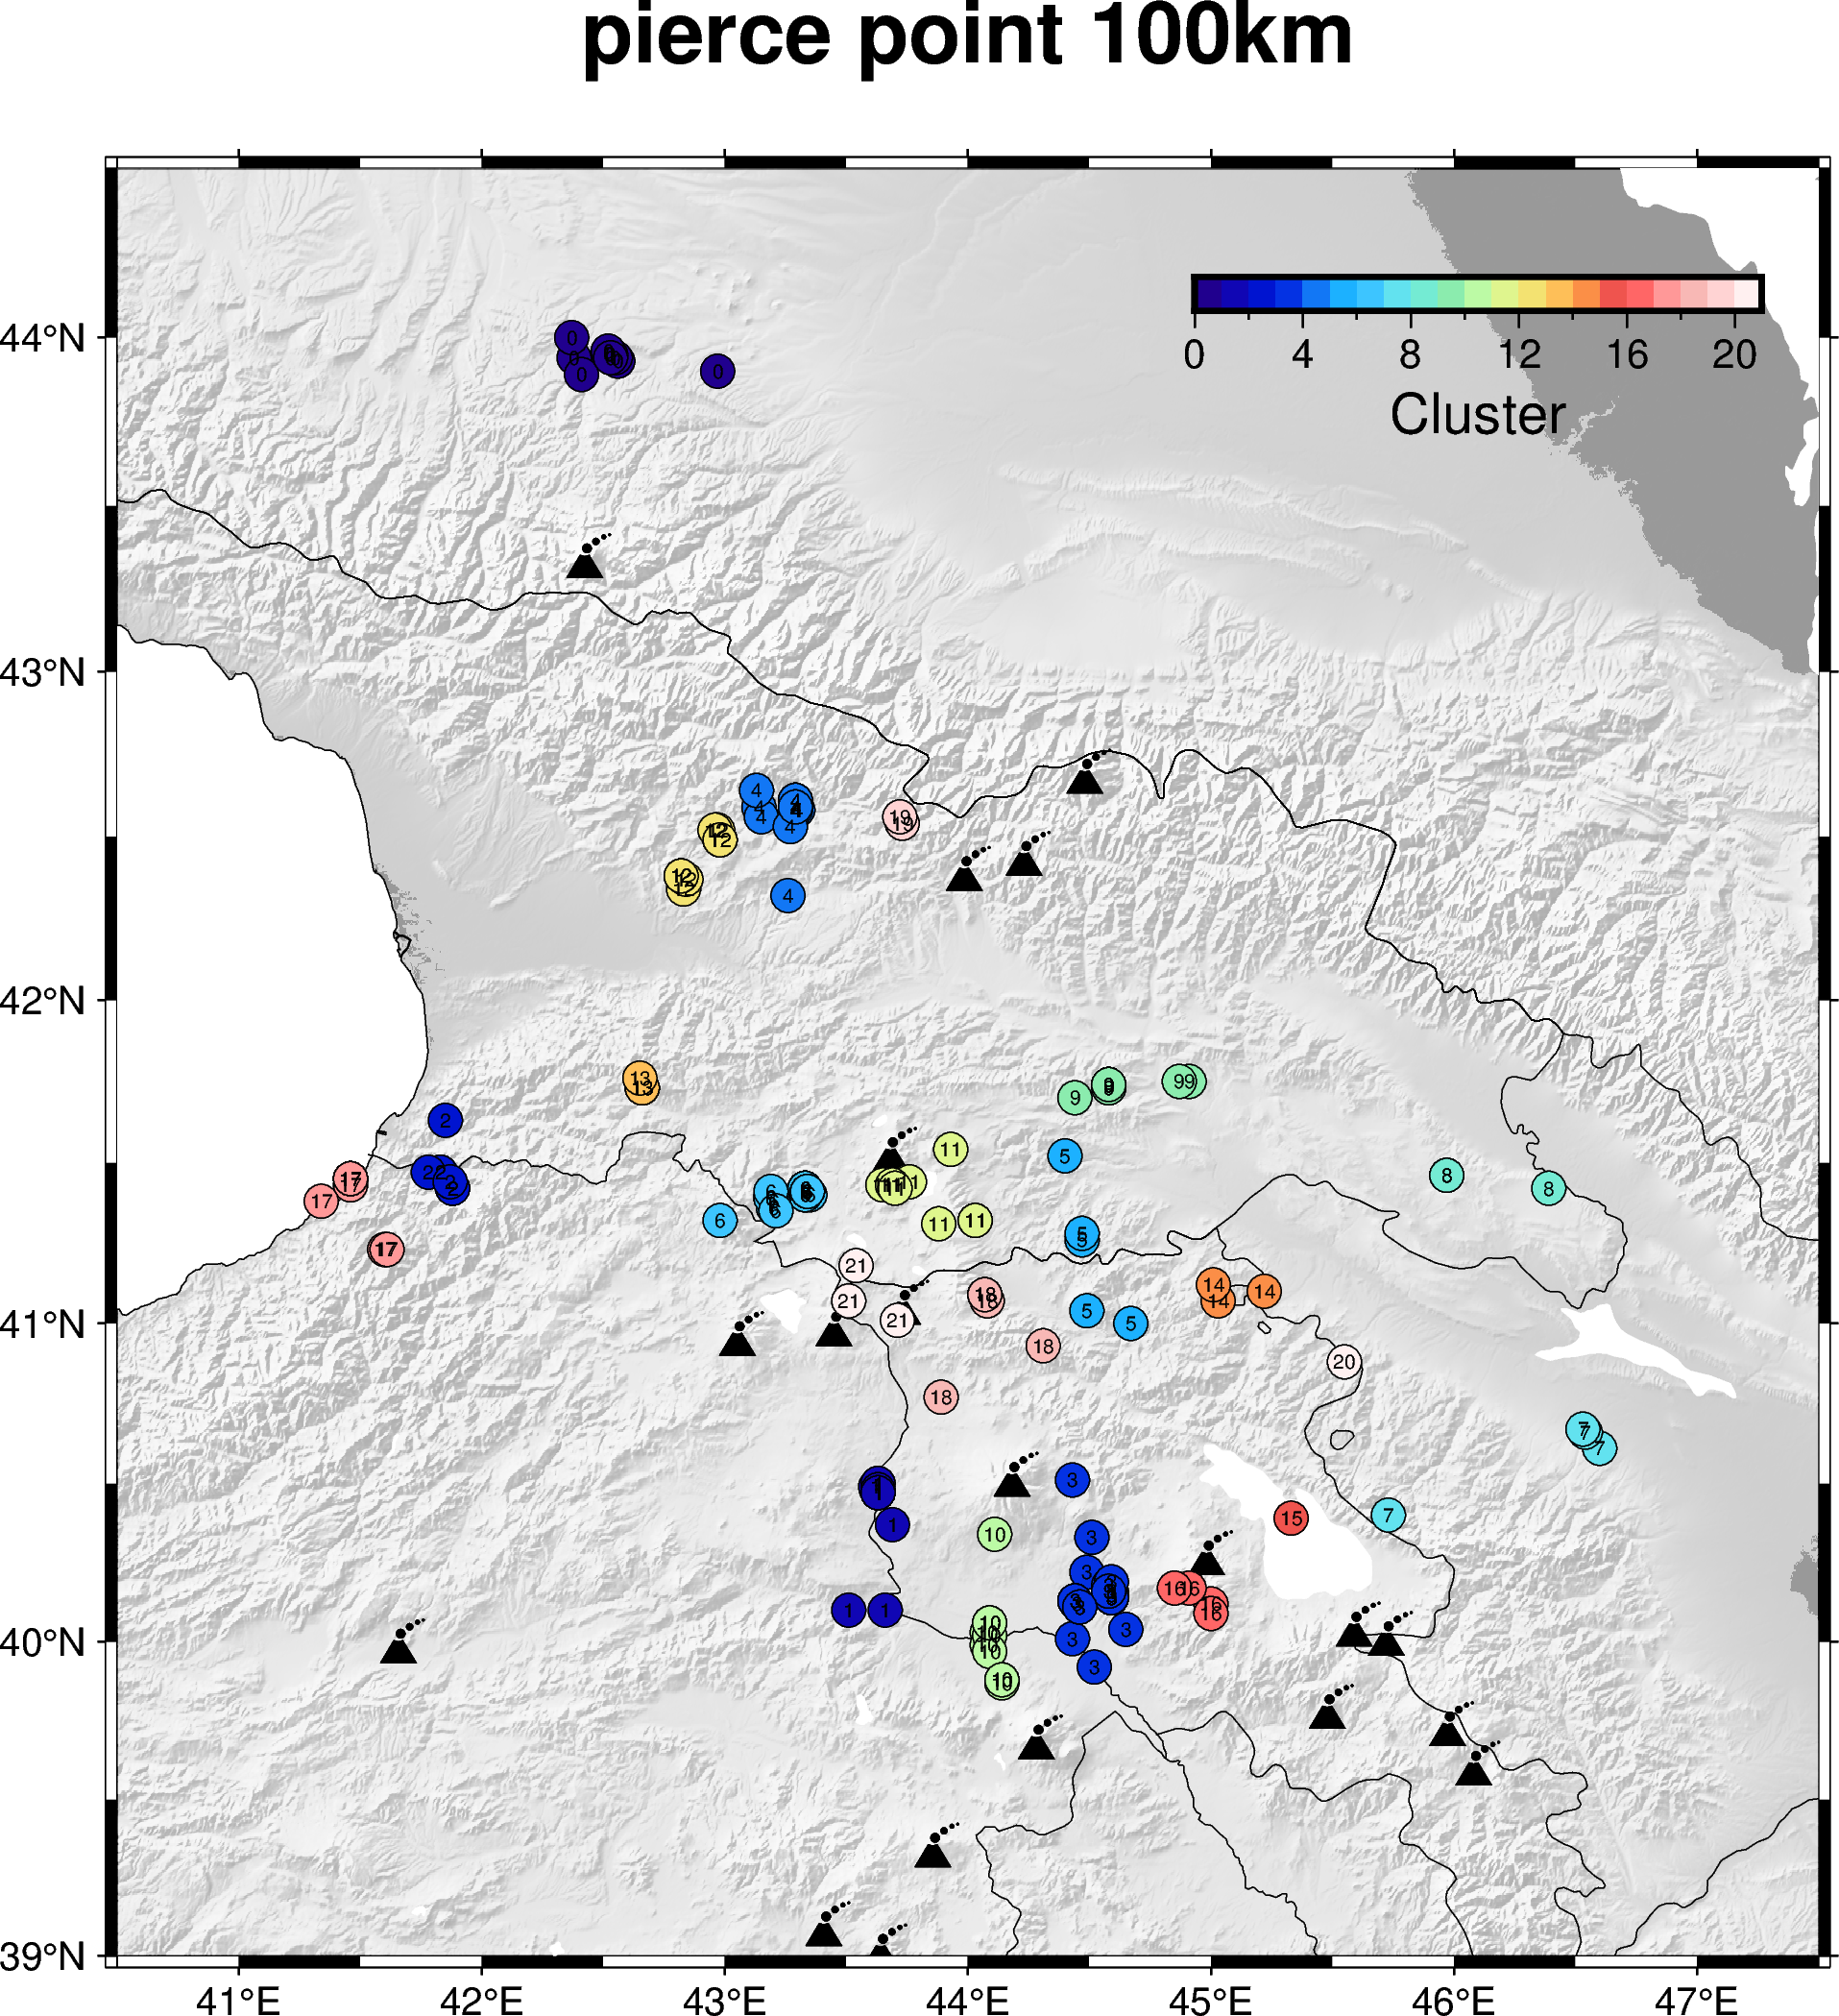

In [50]:
dc =pd.read_csv(f'Cluster_{PierceDep}/PP{PierceDep}_cluster.csv')
region = [40.5, 47.5, 39, 44.5]
figmap = pygmt.Figure()
title = f"pierce point {PierceDep}km"
PygmtBegin(figmap,region,title)
maxclu = max(dc['cluster'])
qqq=pygmt.makecpt(cmap="haxby", series=[0, maxclu, 1 ], continous=False, output='qqq.cpt')
figmap.plot(x=dc['plon'], y=dc['plat'], 
            style='c0.3c', color=dc['cluster'], 
            cmap='qqq.cpt', pen="black")
figmap.text(x=dc['plon'], y=dc['plat'], text = dc['cluster'], font='5p')
figmap.colorbar(cmap='qqq.cpt', position="x9.5c/14.5c+w5c/0.3c+h",frame=["a4f2", "x+lCluster"])
figmap.savefig(f'Cluster_{PierceDep}/ClusterMap.png',dpi=200)
figmap.savefig(f'Cluster_{PierceDep}/ClusterMap.pdf')
figmap.show()

In [51]:
def angle_mean(dt, phi):
    import numpy as np
    dt=np.array(dt)
    phi=np.array(phi)
    x = dt*np.cos(2*phi*np.pi/180.0)
    y = dt*np.sin(2*phi*np.pi/180.0)
    c = x + 1j*y
    m = np.mean(c)

    phase = np.angle(m, deg=True)/2.
    radius = np.abs(m)

    return phase, radius

In [52]:
clusdf = {'Cluster':[],
          'length':[],
         'clon':[],
         'clat':[],
         'meanphi':[],
         'meandt':[]  }
maxclu = max(dc['cluster'])

for i in range(maxclu):
    
    dff = dc[dc['cluster']==i]
    length = len(dff)
    Clon = np.mean(dff['plon'])
    Clat = np.mean(dff['plat'])

    avg_phi, avg_dt = angle_mean(dff['dt'], dff['phi'])
    avg_phi = int(avg_phi)
    
    clusdf['Cluster'].append(i)
    clusdf['length'].append(length)
    clusdf['clon'].append(Clon)
    clusdf['clat'].append(Clat)
    clusdf['meanphi'].append(avg_phi)
    clusdf['meandt'].append(avg_dt)
    
    print(f'=================Cluster{i} finish')
clusdf = pd.DataFrame(clusdf)
clusdf.to_csv(f'Cluster_{PierceDep}/01_Cluster_mean.csv',index=False )

=================Cluster0 finish
=================Cluster1 finish
=================Cluster2 finish
=================Cluster3 finish
=================Cluster4 finish
=================Cluster5 finish
=================Cluster6 finish
=================Cluster7 finish
=================Cluster8 finish
=================Cluster9 finish
=================Cluster10 finish
=================Cluster11 finish
=================Cluster12 finish
=================Cluster13 finish
=================Cluster14 finish
=================Cluster15 finish
=================Cluster16 finish
=================Cluster17 finish
=================Cluster18 finish
=================Cluster19 finish
=================Cluster20 finish


21


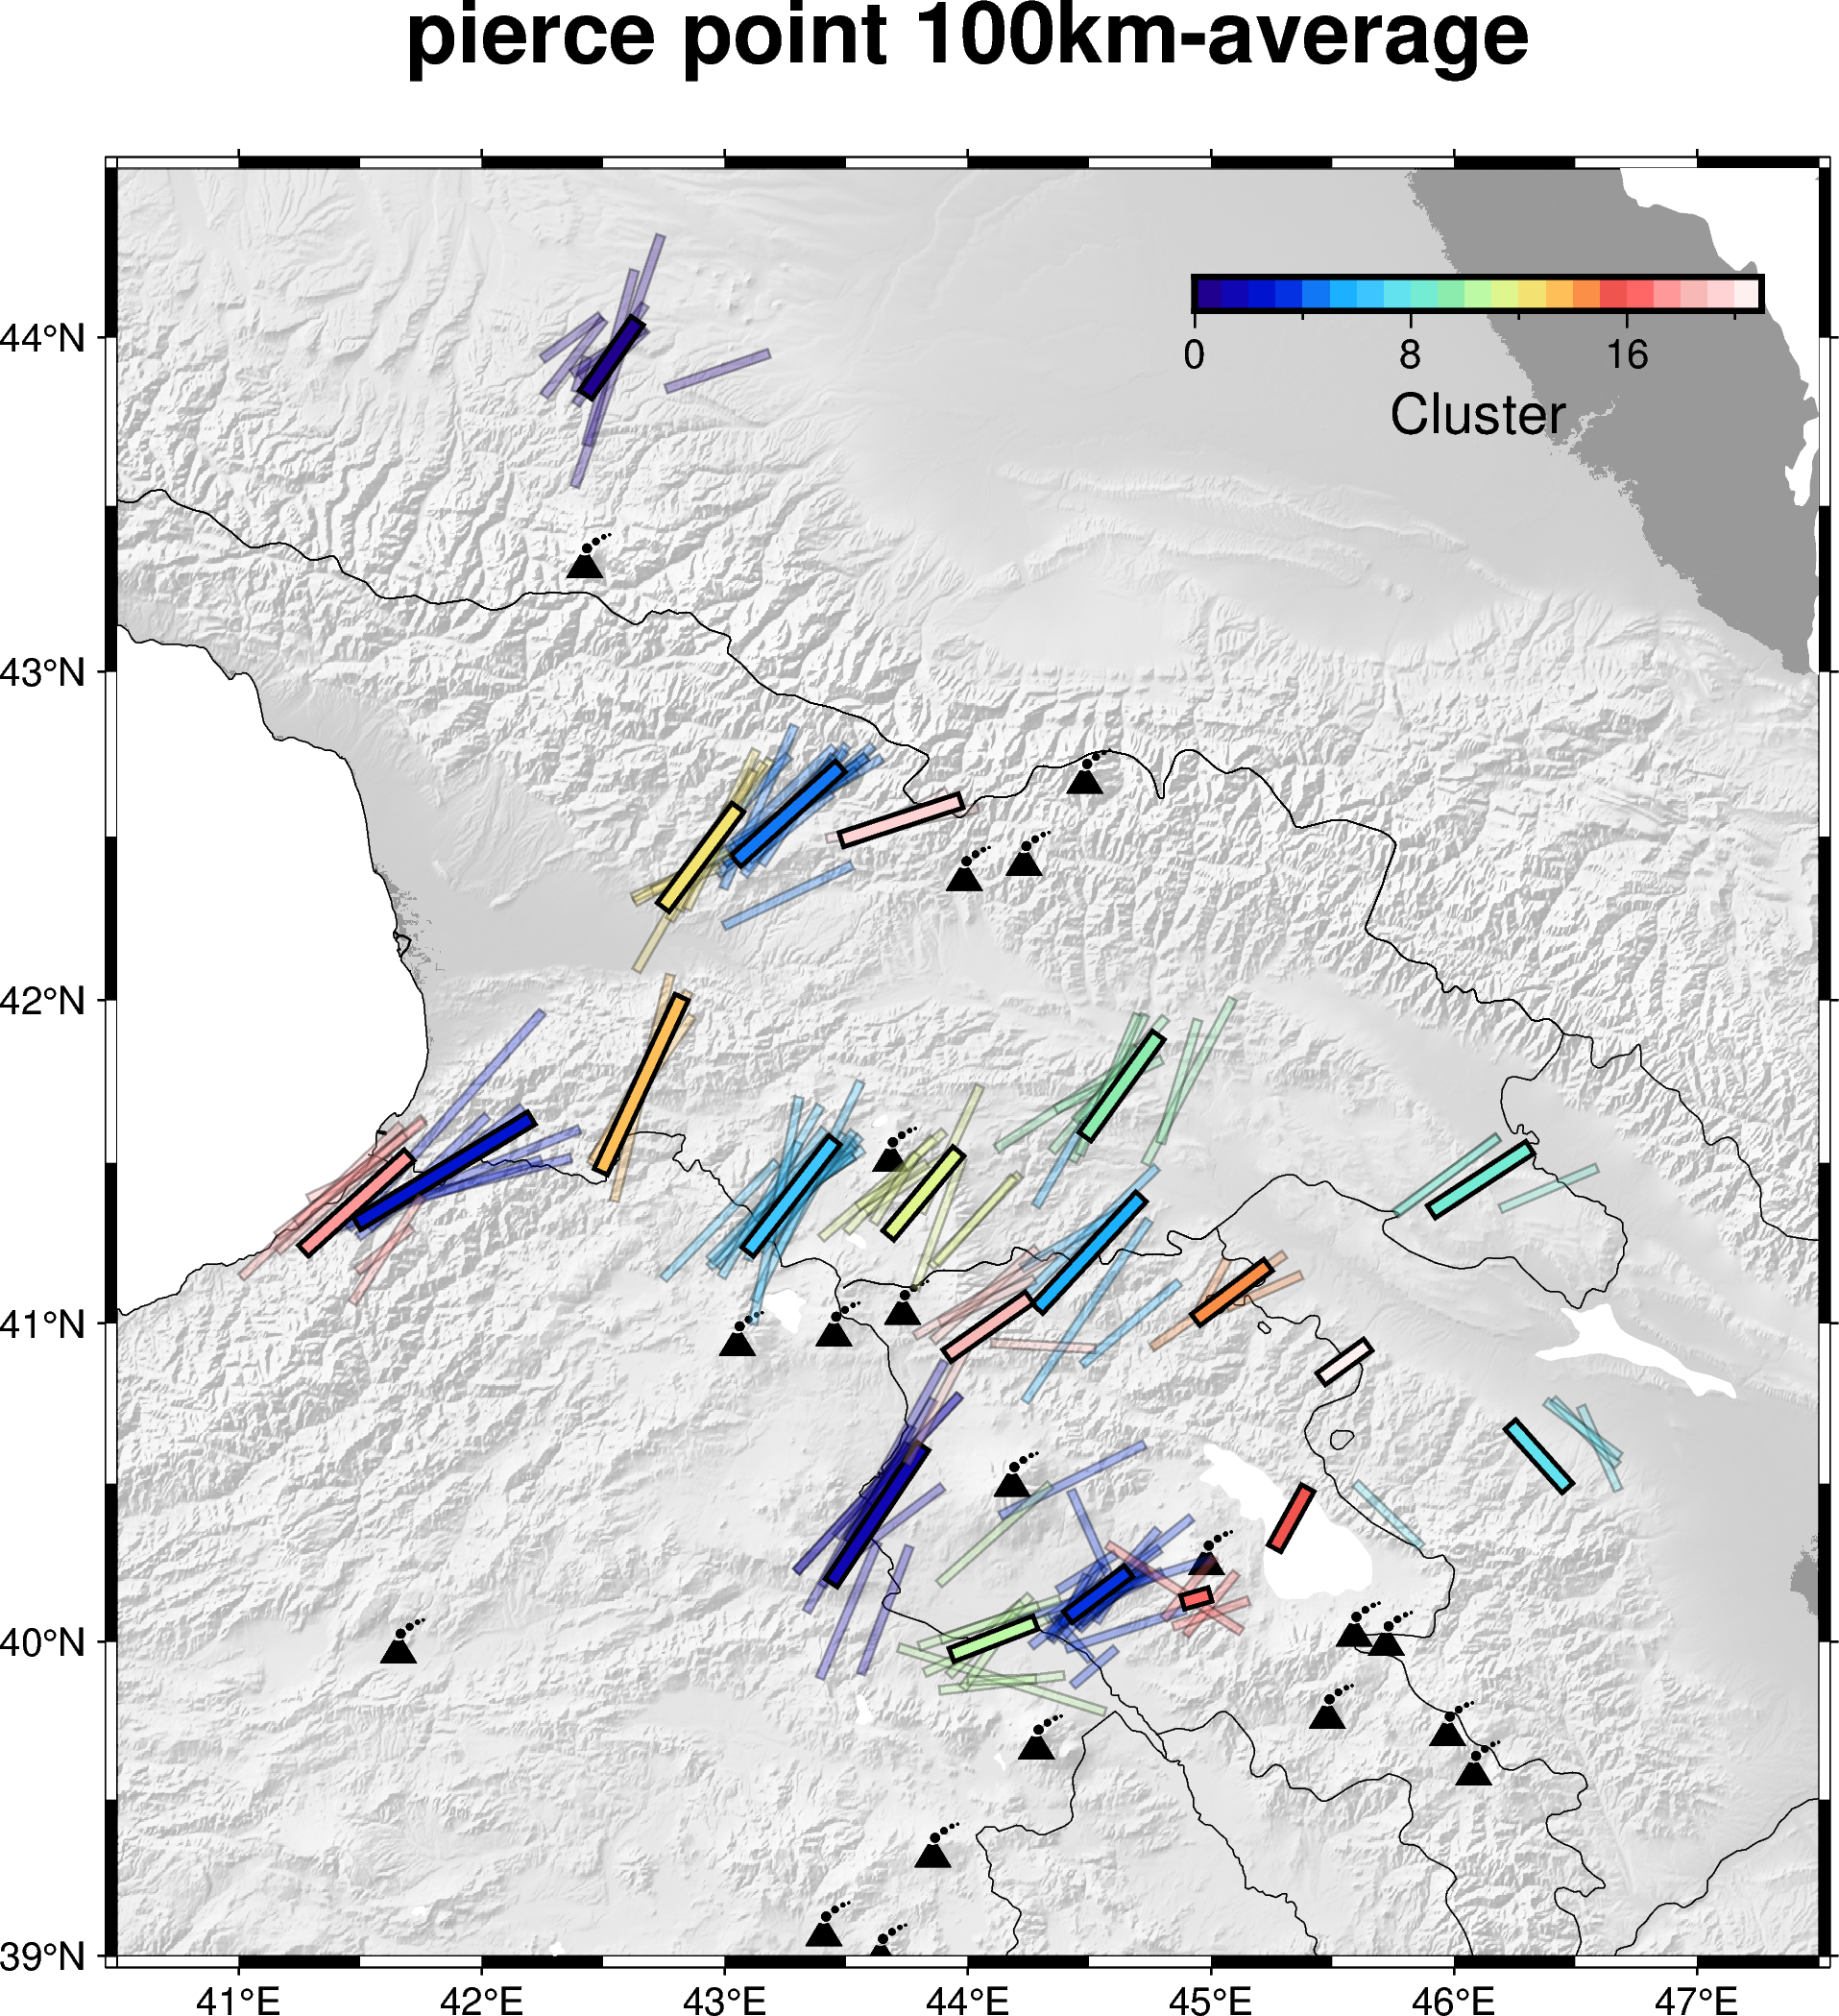

In [53]:
df = pd.read_csv(f'Cluster_{PierceDep}/PP{PierceDep}_cluster.csv')
dcolor = pd.read_csv('qqq.cpt', sep='\s+', names = ['begin', 'color1', 'end', 'color2','q'])
dclu   = pd.read_csv(f'Cluster_{PierceDep}/01_Cluster_mean.csv')
region = [40.5, 47.5, 39, 44.5]
title = f"pierce point {PierceDep}km-average"
figmap = pygmt.Figure()
PygmtBegin(figmap,region,title)
maxclu = max(df['cluster'])
print(maxclu)


for i in range(maxclu):
    dff = df[df['cluster']==i]
    length = len(dff)
    color = dcolor['color1'][dcolor['begin']==str(i)].values[0]
    for j in range(length):
        sta = dff['Station'].values[j]
        phi = dff['phi'].values[j]
        dt  = dff['dt'].values[j]
        p_lon = dff['plon'].values[j]
        p_lat = dff['plat'].values[j]
   
        data = [[p_lon, p_lat, phi-90, 3, dt*40]]
        figmap.plot(data=data, style="J", color=color, pen="0.5p,black",transparency=70, no_clip=True)

    cclon = dclu['clon'][dclu['Cluster']==i].values[0]
    cclat = dclu['clat'][dclu['Cluster']==i].values[0]
    ccphi = dclu['meanphi'][dclu['Cluster']==i].values[0]
    ccdt = dclu['meandt'][dclu['Cluster']==i].values[0]
    ccdata = [[cclon, cclat, ccphi-90, 5, ccdt*40]]
    figmap.plot(data=ccdata, style="J", color=color, pen="1p,black", no_clip=True)

figmap.colorbar(cmap='qqq.cpt', position="x9.5c/14.5c+w5c/0.3c+h",frame=["a8f4", "x+lCluster"])
figmap.savefig(f'Cluster_{PierceDep}/01_Cluster_phi_v2.png',dpi=200)
figmap.savefig(f'Cluster_{PierceDep}/01_Cluster_phi_v2.pdf')
figmap.show()

In [62]:
cluster = [6,11,9,5,18,21]
philist = []
dtlist  = []
for cc in cluster:
    dff = df[df['cluster']==cc]
    for ii in range(len(dff)):
        phi = dff['phi'].values[ii]
        dt = dff['dt'].values[ii]
        philist.append(phi)
        dtlist.append(dt)
    
avg_phi, avg_dt = angle_mean(dtlist, philist)
print(avg_phi, avg_dt)

41.198203931 1.05681519019
